In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt


In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = 'D:/Desktop/Image-super-esolution/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_img = []
path = 'D:/Desktop/Image-super-esolution/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))


100%|██████████| 855/855 [00:20<00:00, 41.50it/s]


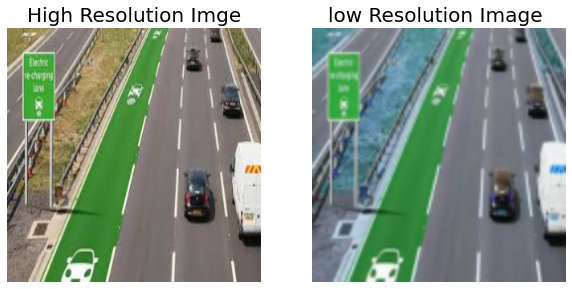

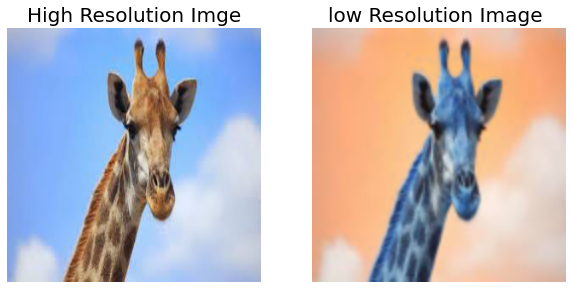

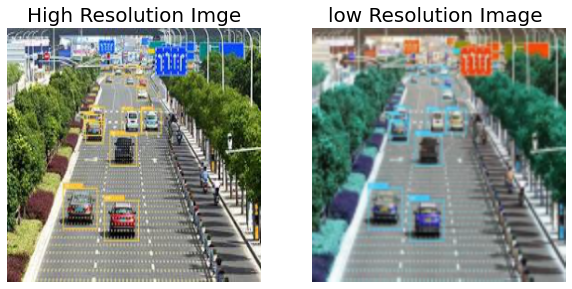

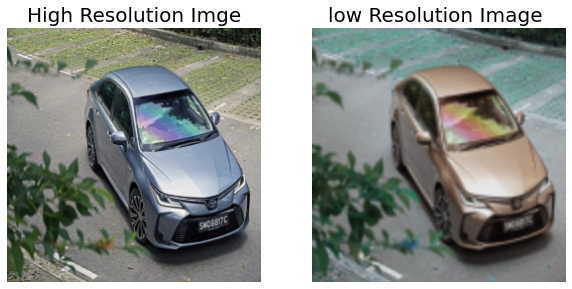

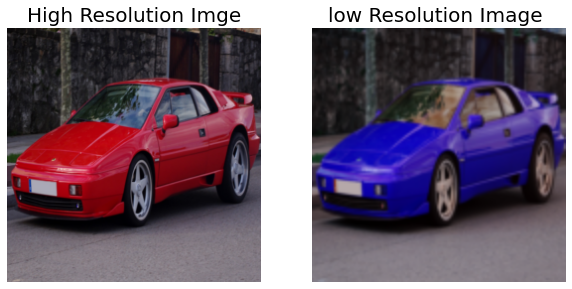

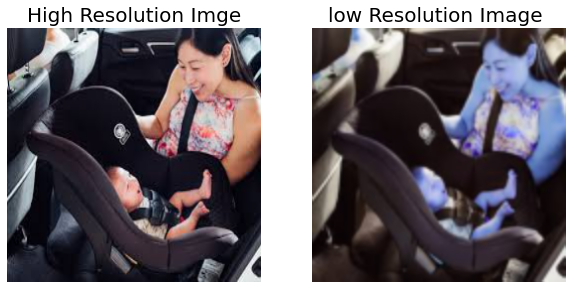

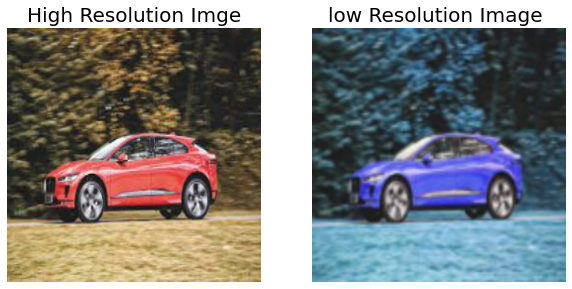

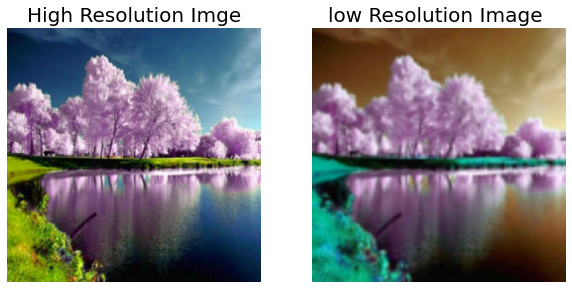

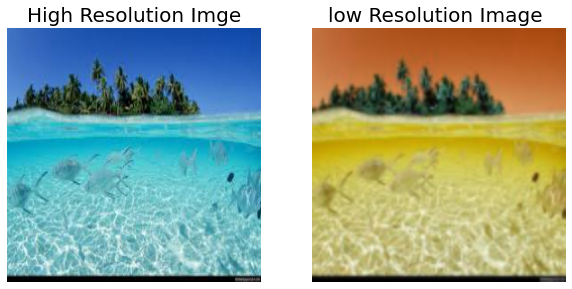

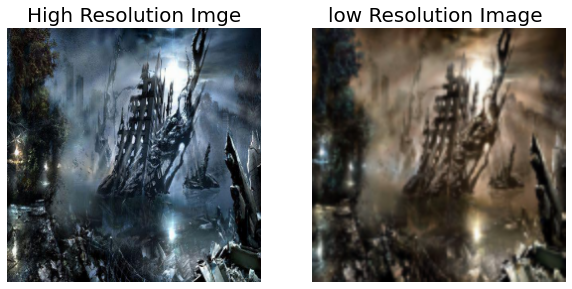

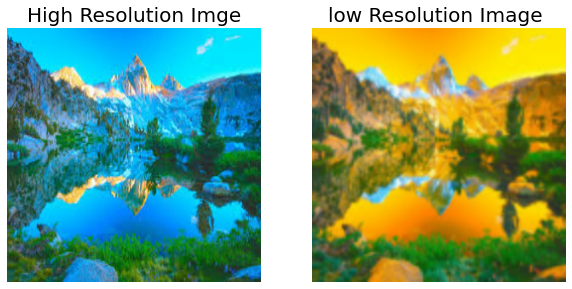

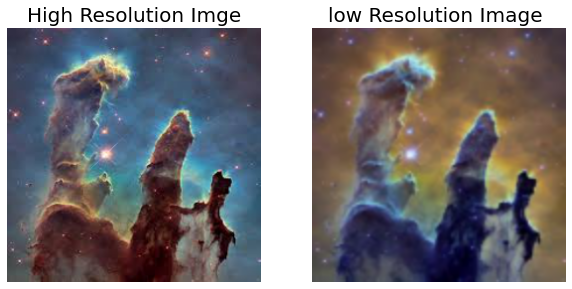

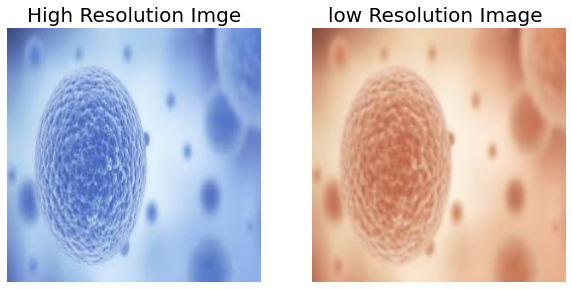

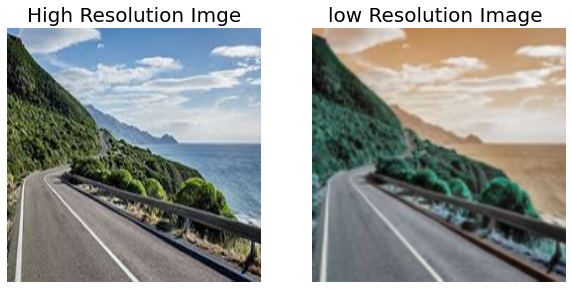

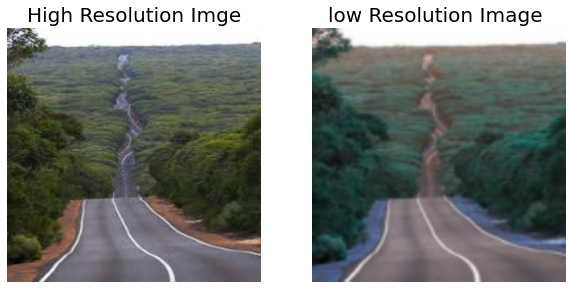

In [3]:
for i in range(15):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))

test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [5]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [8]:
model.fit(train_low_image, train_high_image, epochs = 10, batch_size = 1, validation_data = (validation_low_image,validation_high_image))


Epoch 1/10
700/700 [==============================] - 324s 462ms/step - loss: 0.0470 - acc: 0.6712 - val_loss: 0.0359 - val_acc: 0.7998
Epoch 2/10
700/700 [==============================] - 321s 458ms/step - loss: 0.0275 - acc: 0.7820 - val_loss: 0.0240 - val_acc: 0.8064
Epoch 3/10
700/700 [==============================] - 343s 490ms/step - loss: 0.0233 - acc: 0.7961 - val_loss: 0.0214 - val_acc: 0.8089
Epoch 4/10
700/700 [==============================] - 335s 478ms/step - loss: 0.0212 - acc: 0.8137 - val_loss: 0.0192 - val_acc: 0.8135
Epoch 5/10
700/700 [==============================] - 424s 606ms/step - loss: 0.0202 - acc: 0.8314 - val_loss: 0.0190 - val_acc: 0.9013
Epoch 6/10
700/700 [==============================] - 423s 604ms/step - loss: 0.0195 - acc: 0.8341 - val_loss: 0.0199 - val_acc: 0.8457
Epoch 7/10
700/700 [==============================] - 508s 726ms/step - loss: 0.0185 - acc: 0.8392 - val_loss: 0.0198 - val_acc: 0.9038
Epoch 8/10
700/700 [============================

1/1 [==============================] - 1s 650ms/step


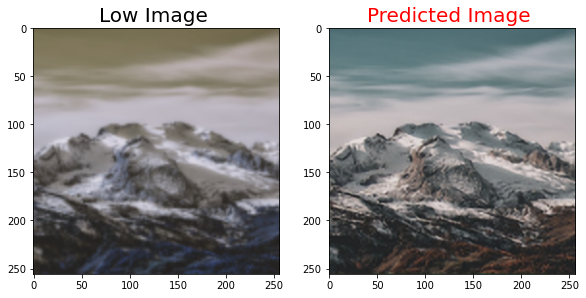

1/1 [==============================] - 0s 139ms/step


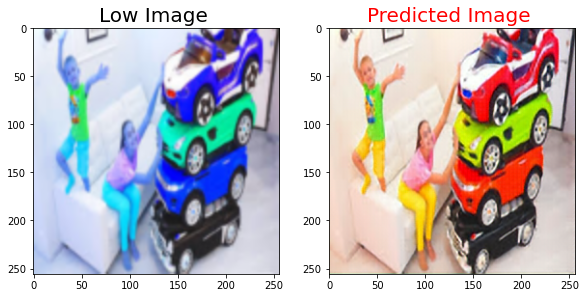

1/1 [==============================] - 0s 125ms/step


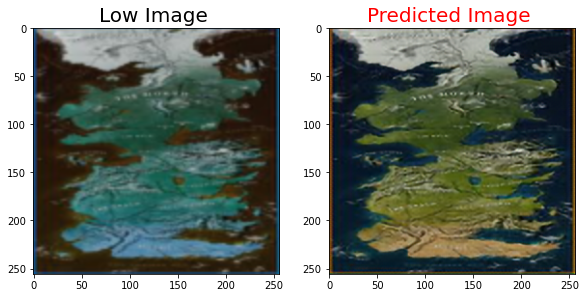

1/1 [==============================] - 0s 141ms/step


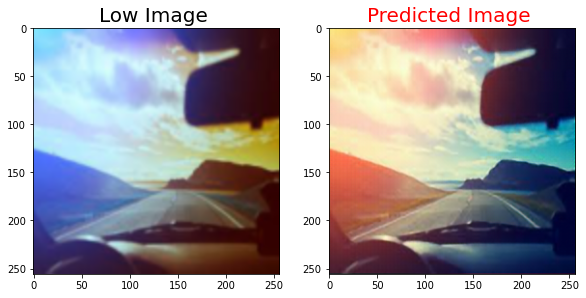

1/1 [==============================] - 0s 132ms/step


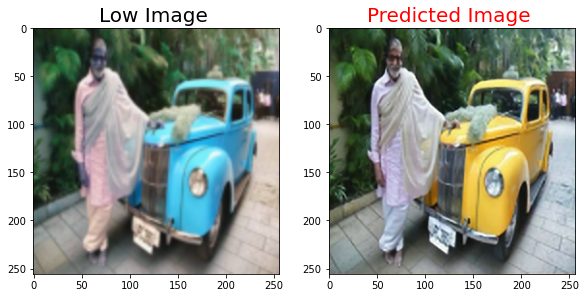

In [9]:
def plot_images(low,predicted):
    plt.figure(figsize=(15,15))
    # plt.subplot(1,3,1)
    # plt.title('High Image', color = 'green', fontsize = 20)
    # plt.imshow(high)
    plt.subplot(1,3,1)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,2)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(15,20):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_low_image[i],predicted)